In [6]:
# this is an input-output file, which takes the fits file as an input and gives us a white image of the data cube by suming all the values of the wavelength axis
# importing the required libraries
from musetools import io as io
import matplotlib.pyplot as plt
from musetools import spec as s
import numpy as np
import getpass
from astropy.convolution import Gaussian2DKernel, convolve
from matplotlib import mlab, cm
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

from importlib import reload

reload(io)

from copy import deepcopy

%matplotlib inline
username=getpass.getuser()

if username == 'bordoloi':
	fitsfile = '/Users/bordoloi/Dropbox/MUSE/LensedArc/RCS0327_16mc_zap.fits'
else:
	fitsfile = '/home/ahmed/astro/data/RCS0327_16mc_zap.fits'
#input("Enter the path to your file: ")


wave, data, var, header = io.open_muse_cube(fitsfile)
header2d=io.tweak_header(header)

q=np.isnan(data)
data[q]=0.


#w = WCS(header)
zgal= 1.7037455
wrest = wave/(1.+zgal)


wl_min = 6500.#6930.
wl_max = 8500.5#6950.
wl_image = io.narrow_band(wl_min, wl_max, wave, data,plot=False)


Text(0.5, 1.0, 'White Light Image')

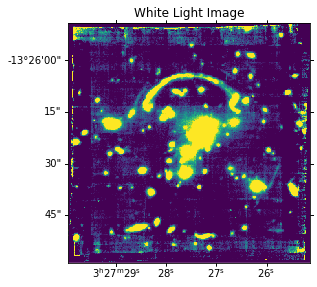

In [19]:
#Original cube to be used

zmin=1
zmax=2000.

width_in = 10
fig=plt.figure(1, figsize=(width_in, 15))
ax = fig.add_subplot(311,projection=WCS(header2d))
ax.imshow( wl_image, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax.set_title('White Light Image')



In [40]:
#Function to perform the image cutout... eventually merge into musetools
def trim_cube_with_header(fluxfile,size = (200, 100), position = (200., 250.)):
    """ Trims MUSE ZAP datacube to remove bad pixels and reconstructs the header

    Parameters:
    ----------
    fluxfile  : name of the flux file
    size= (y,x) size of the cutout image in pixels
    position = (y,x) central position of the cutout in pixels

    Returns:
    ----------
    newflux, newvar :  New trimmed flux and variance cubes
    newhdr_flx,newhrd_var: new updated headers
    """
    wave, fluxmsky, var, hdu_hdr = io.open_muse_cube(fitsfile)
    crval3 = hdu_hdr['CRVAL3']
    crpix3 = hdu_hdr['CRPIX3']
    cd3_3 = hdu_hdr['CD3_3']
    wavedim = hdu_hdr['NAXIS3']


    
    wavedim, ydim, xdim = fluxmsky.shape
    
    header =io.tweak_header(deepcopy(hdu_hdr))
    

    
    q=np.isnan(fluxmsky)
    fluxmsky[q]=0.
    qq=np.isnan(var)
    fluxmsky[q]=0.
    #position = (16.5, 47.5)
    #size = (66, 25)     # pixels


    newflux=np.zeros((wavedim,size[0],size[1]))
    newvar=np.zeros((wavedim,size[0],size[1]))

    cutout=Cutout2D(fluxmsky[0,:,:], position, size, wcs=WCS(header))
    
    
    index=cutout.bbox_original
    
    newflux=fluxmsky[:,index[0][0]:index[0][1],index[1][0]:index[1][1]]
    newvar=var[:,index[0][0]:index[0][1],index[1][0]:index[1][1]]

    
    
    
    # Construct new header
    
    temp=cutout.wcs.to_header()

    
    newhdr_flx=deepcopy(hdu_hdr)
    newhdr_flx['NAXIS1']=size[1]
    newhdr_flx['NAXIS2']=size[0]
    newhdr_flx['CRPIX1']=temp['CRPIX1']
    newhdr_flx['CRPIX2']=temp['CRPIX2']
    newhdr_flx['CRVAL3']=crval3
    newhdr_flx['CRPIX3']=crpix3
    newhdr_flx['CD3_3']=cd3_3
    newhdr_flx['NAXIS3']=wavedim

    
    
    
    return newflux,newvar,newhdr_flx





In [41]:
size = (80, 180)
position = (180., 250.)
s,sv,h=trim_cube_with_header(fitsfile,size=size,position=position)
cutout=Cutout2D(wl_image, position, size, wcs=WCS(header2d))

Text(0.5, 1.0, 'White Light Image')

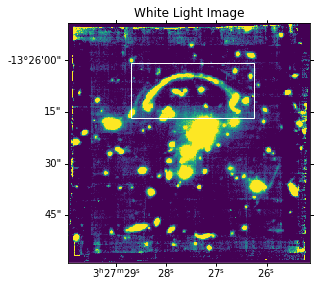

In [42]:
zmin=1
zmax=2000.

width_in = 10
fig=plt.figure(1, figsize=(width_in, 15))
ax = fig.add_subplot(311,projection=WCS(header2d))
ax.imshow( wl_image, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
cutout.plot_on_original(color='white')

ax.set_title('White Light Image')


In [44]:
from astropy.io import fits
#create a new datacube
hdu1 = fits.PrimaryHDU(s,header=h)
hdu2 = fits.ImageHDU(sv,header=h)
new_hdul = fits.HDUList([hdu1, hdu2])
outfile='/Users/bordoloi/Dropbox/MUSE/LensedArc/test.fits'
new_hdul.writeto(outfile, overwrite=True)
print("Wrote cube to {}".format(outfile))


Wrote cube to /Users/bordoloi/Dropbox/MUSE/LensedArc/test.fits


In [5]:
header2d

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  352 / length of data axis 1                          
NAXIS2  =                  349 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '           / Image data format                              
HDUCLAS2= 'DATA    '        